In [ ]:
!pwd

# 1. Download Dataset from [Kaggle](https://www.kaggle.com/datasets/keerthicheepurupalli/malimg-dataset9010)

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d keerthicheepurupalli/malimg-dataset9010


In [ ]:
!unzip -qq /content/malimg-dataset9010.zip 


# PyTorch


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import torchvision.models as models

import numpy as np


# Load the MALIMG dataset and split it into training and validation sets


In [2]:
train_dset_path  = '/content/dataset_9010/dataset_9010/malimg_dataset/train'
test_dset_path   = '/content/dataset_9010/dataset_9010/malimg_dataset/validation'

re_size = (256,256)

transform = transforms.Compose([
    transforms.Resize(re_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# transform = transforms.Compose([transforms.Grayscale(), transforms.Resize((256, 256)), transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root=train_dset_path, transform=transform)
test_data   = torchvision.datasets.ImageFolder(root=test_dset_path, transform=transform)


In [3]:
num_classes = len(train_data.classes)
print(num_classes)


25


In [4]:
len(train_data),len(test_data)

(8404, 935)

In [36]:
train_data, val_data = torch.utils.data.random_split(train_data, [int(0.8*len(train_data)), len(train_data) - int(0.8*len(train_data))])
len(train_data) + len(val_data)
print(len(train_data), len(val_data),len(test_data))

4302 1076 935


# Get a batch of images from the DataLoader


In [6]:
train_data.dataset.class_to_idx

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

tensor([11,  7,  2,  2, 22,  2,  5, 22, 12,  9, 22,  2, 24,  5, 22, 10, 10,  7,
        12,  3, 10,  2,  3,  9,  3, 11, 24,  2, 21, 24,  2, 19])


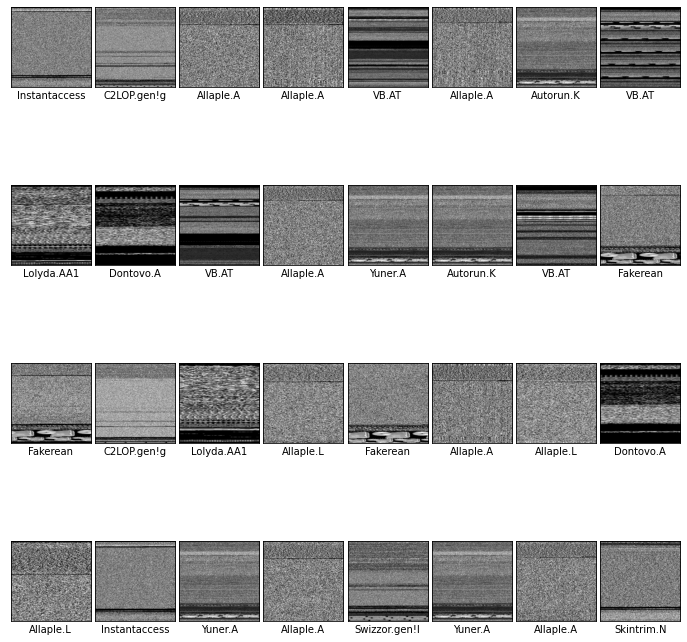

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

mydict = train_data.dataset.class_to_idx

def plot_images_with_labels(images, labels, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.5, wspace=0.05)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i][0], cmap='gray')
        label = list(mydict.keys())[list(mydict.values()).index(labels[i])]
        ax.set_xlabel(label)
    plt.show()

# Load the data using a PyTorch data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# Get a batch of data from the data loader
images, labels = next(iter(train_loader))
print(labels)

# Plot the images along with their class labels
plot_images_with_labels(images, labels, nrows=4, ncols=8)


# Model- Resnet 34 

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)



In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = models.resnet34(pretrained=True).to(device)

cuda:0


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Freeze the parameters of the pre-trained layers to prevent them from being updated during training
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer of the ResNet34 model with a new fully connected layer to classify images into the desired number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, out_features=num_classes)
model = model.cuda()
print(model.fc)



Linear(in_features=512, out_features=25, bias=True)


In [11]:
# Use a cross-entropy loss function and an optimizer such as SGD or Adam
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)


# Model summary

In [12]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)
summary(model, input_size=(3,256,256))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1

# Train and validate a PyTorch model with accuracy

In [13]:
import matplotlib.pyplot as plt

from tqdm import tqdm

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

test_losses = []
test_accuracies = []

In [14]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer):
    # Train the model
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    total = 0
    processed = 0

    # for inputs, labels in train_loader:
    # for i, data in enumerate(train_loader, 0):
    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Update pbar-tqdm
        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        processed += len(inputs)

        pbar.set_description(desc= f'Train set\t:Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        #####
        train_loss += loss.item()
        # _, predicted = torch.max(outputs.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100 * correct / processed) 
    # train_accuracies.append(100 * correct / total)

def val(model, device, loader):
    # Validate the model
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(loader)

    with torch.no_grad():
        # for inputs, labels in val_loader:
        for i, data in enumerate(pbar):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(100 * correct / total)
    print('Val set\t\t: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        val_loss, 
        correct, 
        len(loader.dataset),
        100. * correct / len(loader.dataset))
    )
    

def test(model, device, loader):
    # Validate the model
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        # for inputs, labels in loader:
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(loader)
    test_losses.append(test_loss)
    test_accuracies.append(100 * correct / total)
    print('Test set\t: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, 
        len(loader.dataset),
        100. * correct / len(loader.dataset))
    )
    

In [15]:
num_epochs = 20

for epoch in range(1,num_epochs+1):
  print(f'#### Epoch : {epoch}')
  train(model, device, train_loader, optimizer)
  val(model, device, loader=val_loader)
  test(model, device, loader=test_loader)


#### Epoch : 0


Loss=0.11085841804742813 Batch_id=52 Accuracy=83.85: 100%|██████████| 53/53 [00:39<00:00,  1.34it/s]


Validation set: Average loss: 0.1926, Accuracy: 1603/1681 (95.36%)
Test set: Average loss: 0.3267, Accuracy: 843/935 (90.16%)
#### Epoch : 1


Loss=0.1571750044822693 Batch_id=52 Accuracy=96.62: 100%|██████████| 53/53 [00:38<00:00,  1.36it/s]


Validation set: Average loss: 0.1219, Accuracy: 1625/1681 (96.67%)
Test set: Average loss: 0.2097, Accuracy: 872/935 (93.26%)
#### Epoch : 2


Loss=0.14084385335445404 Batch_id=52 Accuracy=97.16: 100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Validation set: Average loss: 0.1060, Accuracy: 1629/1681 (96.91%)
Test set: Average loss: 0.1992, Accuracy: 870/935 (93.05%)
#### Epoch : 3


Loss=0.10639803856611252 Batch_id=52 Accuracy=97.32: 100%|██████████| 53/53 [00:38<00:00,  1.39it/s]


Validation set: Average loss: 0.0948, Accuracy: 1629/1681 (96.91%)
Test set: Average loss: 0.1725, Accuracy: 877/935 (93.80%)
#### Epoch : 4


Loss=0.09455011039972305 Batch_id=52 Accuracy=97.71: 100%|██████████| 53/53 [00:42<00:00,  1.24it/s]


Validation set: Average loss: 0.0898, Accuracy: 1634/1681 (97.20%)
Test set: Average loss: 0.1176, Accuracy: 885/935 (94.65%)
#### Epoch : 5


Loss=0.08601368963718414 Batch_id=52 Accuracy=97.72: 100%|██████████| 53/53 [00:40<00:00,  1.32it/s]


Validation set: Average loss: 0.0797, Accuracy: 1637/1681 (97.38%)
Test set: Average loss: 0.1178, Accuracy: 882/935 (94.33%)
#### Epoch : 6


Loss=0.0630645900964737 Batch_id=52 Accuracy=97.68: 100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Validation set: Average loss: 0.0775, Accuracy: 1635/1681 (97.26%)
Test set: Average loss: 0.1450, Accuracy: 877/935 (93.80%)
#### Epoch : 7


Loss=0.020833920687437057 Batch_id=52 Accuracy=97.80: 100%|██████████| 53/53 [00:44<00:00,  1.20it/s]


Validation set: Average loss: 0.0715, Accuracy: 1640/1681 (97.56%)
Test set: Average loss: 0.1292, Accuracy: 884/935 (94.55%)
#### Epoch : 8


Loss=0.07067028433084488 Batch_id=52 Accuracy=98.08: 100%|██████████| 53/53 [00:40<00:00,  1.30it/s]


Validation set: Average loss: 0.0686, Accuracy: 1636/1681 (97.32%)
Test set: Average loss: 0.1089, Accuracy: 883/935 (94.44%)
#### Epoch : 9


Loss=0.014759412035346031 Batch_id=52 Accuracy=98.19: 100%|██████████| 53/53 [00:39<00:00,  1.34it/s]


Validation set: Average loss: 0.0701, Accuracy: 1638/1681 (97.44%)
Test set: Average loss: 0.1254, Accuracy: 881/935 (94.22%)
#### Epoch : 10


Loss=0.06366924941539764 Batch_id=52 Accuracy=98.33: 100%|██████████| 53/53 [00:38<00:00,  1.36it/s]


Validation set: Average loss: 0.0666, Accuracy: 1631/1681 (97.03%)
Test set: Average loss: 0.1025, Accuracy: 879/935 (94.01%)
#### Epoch : 11


Loss=0.06937383860349655 Batch_id=52 Accuracy=98.30: 100%|██████████| 53/53 [00:39<00:00,  1.34it/s]


Validation set: Average loss: 0.0605, Accuracy: 1640/1681 (97.56%)
Test set: Average loss: 0.0988, Accuracy: 885/935 (94.65%)
#### Epoch : 12


Loss=0.08436153829097748 Batch_id=52 Accuracy=98.47: 100%|██████████| 53/53 [00:39<00:00,  1.36it/s]


Validation set: Average loss: 0.0634, Accuracy: 1638/1681 (97.44%)
Test set: Average loss: 0.1182, Accuracy: 891/935 (95.29%)
#### Epoch : 13


Loss=0.041508909314870834 Batch_id=52 Accuracy=98.42: 100%|██████████| 53/53 [00:38<00:00,  1.36it/s]


Validation set: Average loss: 0.0588, Accuracy: 1638/1681 (97.44%)
Test set: Average loss: 0.0992, Accuracy: 883/935 (94.44%)
#### Epoch : 14


Loss=0.036483485251665115 Batch_id=52 Accuracy=98.33: 100%|██████████| 53/53 [00:39<00:00,  1.36it/s]


Validation set: Average loss: 0.0635, Accuracy: 1640/1681 (97.56%)
Test set: Average loss: 0.1335, Accuracy: 882/935 (94.33%)
#### Epoch : 15


Loss=0.0591309629380703 Batch_id=52 Accuracy=98.71: 100%|██████████| 53/53 [00:40<00:00,  1.32it/s]


Validation set: Average loss: 0.0593, Accuracy: 1637/1681 (97.38%)
Test set: Average loss: 0.1014, Accuracy: 883/935 (94.44%)
#### Epoch : 16


Loss=0.033806223422288895 Batch_id=52 Accuracy=98.66: 100%|██████████| 53/53 [00:39<00:00,  1.35it/s]


Validation set: Average loss: 0.0538, Accuracy: 1639/1681 (97.50%)
Test set: Average loss: 0.0896, Accuracy: 886/935 (94.76%)
#### Epoch : 17


Loss=0.03413785621523857 Batch_id=52 Accuracy=98.84: 100%|██████████| 53/53 [00:39<00:00,  1.35it/s]


Validation set: Average loss: 0.0524, Accuracy: 1641/1681 (97.62%)
Test set: Average loss: 0.0946, Accuracy: 886/935 (94.76%)
#### Epoch : 18


Loss=0.07608548551797867 Batch_id=52 Accuracy=98.72: 100%|██████████| 53/53 [00:39<00:00,  1.35it/s]


Validation set: Average loss: 0.0528, Accuracy: 1652/1681 (98.27%)
Test set: Average loss: 0.0839, Accuracy: 912/935 (97.54%)
#### Epoch : 19


Loss=0.031395476311445236 Batch_id=52 Accuracy=98.97: 100%|██████████| 53/53 [00:39<00:00,  1.35it/s]


Validation set: Average loss: 0.0514, Accuracy: 1640/1681 (97.56%)
Test set: Average loss: 0.0899, Accuracy: 883/935 (94.44%)


In [20]:
num_epochs = 10

for epoch in range(1,num_epochs+1):
  print(f'#### Epoch : {epoch}')
  train(model, device, train_loader, optimizer)
  val(model, device, loader=val_loader)
  test(model, device, loader=test_loader)


#### Epoch : 1


Loss=0.03098902478814125 Batch_id=52 Accuracy=98.78: 100%|██████████| 53/53 [00:39<00:00,  1.33it/s]


Validation set: Average loss: 0.0524, Accuracy: 1634/1681 (97.20%)
Test set: Average loss: 0.0966, Accuracy: 885/935 (94.65%)
#### Epoch : 2


Loss=0.02846919558942318 Batch_id=52 Accuracy=98.90: 100%|██████████| 53/53 [00:40<00:00,  1.32it/s]


Validation set: Average loss: 0.0513, Accuracy: 1636/1681 (97.32%)
Test set: Average loss: 0.0889, Accuracy: 885/935 (94.65%)
#### Epoch : 3


Loss=0.0335664302110672 Batch_id=52 Accuracy=98.84: 100%|██████████| 53/53 [00:39<00:00,  1.35it/s]


Validation set: Average loss: 0.0513, Accuracy: 1649/1681 (98.10%)
Test set: Average loss: 0.0849, Accuracy: 910/935 (97.33%)
#### Epoch : 4


Loss=0.058231811970472336 Batch_id=52 Accuracy=99.08: 100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Validation set: Average loss: 0.0526, Accuracy: 1636/1681 (97.32%)
Test set: Average loss: 0.0970, Accuracy: 884/935 (94.55%)
#### Epoch : 5


Loss=0.0380459725856781 Batch_id=52 Accuracy=98.93: 100%|██████████| 53/53 [00:39<00:00,  1.34it/s]


Validation set: Average loss: 0.0480, Accuracy: 1654/1681 (98.39%)
Test set: Average loss: 0.0783, Accuracy: 910/935 (97.33%)
#### Epoch : 6


Loss=0.018239825963974 Batch_id=52 Accuracy=99.17: 100%|██████████| 53/53 [00:38<00:00,  1.36it/s]


Validation set: Average loss: 0.0491, Accuracy: 1641/1681 (97.62%)
Test set: Average loss: 0.0952, Accuracy: 882/935 (94.33%)
#### Epoch : 7


Loss=0.07484302669763565 Batch_id=52 Accuracy=99.12: 100%|██████████| 53/53 [00:38<00:00,  1.36it/s]


Validation set: Average loss: 0.0466, Accuracy: 1639/1681 (97.50%)
Test set: Average loss: 0.0848, Accuracy: 886/935 (94.76%)
#### Epoch : 8


Loss=0.031849008053541183 Batch_id=52 Accuracy=99.15: 100%|██████████| 53/53 [00:39<00:00,  1.36it/s]


Validation set: Average loss: 0.0470, Accuracy: 1653/1681 (98.33%)
Test set: Average loss: 0.0731, Accuracy: 910/935 (97.33%)
#### Epoch : 9


Loss=0.037792909890413284 Batch_id=52 Accuracy=99.14: 100%|██████████| 53/53 [00:39<00:00,  1.36it/s]


Validation set: Average loss: 0.0453, Accuracy: 1654/1681 (98.39%)
Test set: Average loss: 0.0764, Accuracy: 908/935 (97.11%)
#### Epoch : 10


Loss=0.03319649025797844 Batch_id=52 Accuracy=99.29: 100%|██████████| 53/53 [00:39<00:00,  1.35it/s]


Validation set: Average loss: 0.0457, Accuracy: 1655/1681 (98.45%)
Test set: Average loss: 0.0803, Accuracy: 911/935 (97.43%)


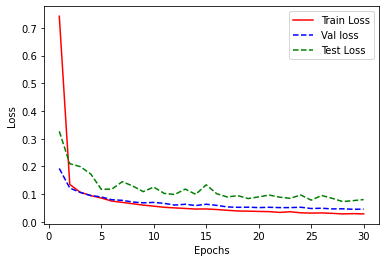

In [28]:
import matplotlib.pyplot as plt

x = list(range(1,len(train_losses)+1))

plt.plot(x, train_losses, label='Train Loss', color='red', linestyle='solid')
plt.plot(x, val_losses, label='Val loss', color='blue', linestyle='dashed')
plt.plot(x, test_losses, label='Test Loss', color='green', linestyle='dashed')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

In [24]:
len(train_accuracies),len(val_accuracies),len(test_accuracies)

(30, 30, 30)

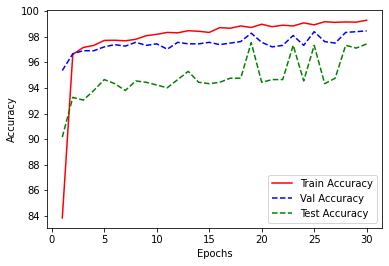

In [30]:
x = list(range(1,len(train_accuracies)+1))

plt.plot(x, train_accuracies, label='Train Accuracy', color='red', linestyle='solid')
plt.plot(x, val_accuracies, label='Val Accuracy', color='blue', linestyle='dashed')
plt.plot(x, test_accuracies, label='Test Accuracy', color='green', linestyle='dashed')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


# Save model

In [21]:
PATH = '/content/model_99_98_97_acc.pth'
torch.save(model.state_dict(), PATH)


In [34]:
!ls -ltrh

total 1.5G
drwxr-xr-x 1 root root 4.0K Feb  2 14:40 sample_data
-rw-r--r-- 1 root root   70 Feb  6 05:50 kaggle.json
-rw-r--r-- 1 root root 1.3G Feb  6 05:51 malimg-dataset9010.zip
drwxr-xr-x 3 root root 4.0K Feb  6 05:52 dataset_9010
drwxr-xr-x 3 root root 4.0K Feb  6 05:52 validation_ds_update_924
-rw-r--r-- 1 root root  82M Feb  6 08:17 model.pth
-rw-r--r-- 1 root root  82M Feb  6 08:33 model_99_98_97_acc.pth
-rw-r--r-- 1 root root  76M Feb  6 08:44 files.zip


In [32]:
!zip files model_99_98_97_acc.pth

  adding: model_99_98_97_acc.pth (deflated 7%)


In [33]:
!zip -sf files.zip

Archive contains:
  model_99_98_97_acc.pth
Total 1 entries (85332033 bytes)


# Inference: